In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [51]:
class convBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(convBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
    def forward(self, x):
        return self.conv(x)

In [52]:
class denseBlock(nn.Module):
    def __init__(self, num_conv,in_channels, out_channels):
        super(denseBlock, self).__init__()
        layer = []
        for i in range(num_conv):
            layer.append(convBlock(in_channels+i*out_channels, out_channels))
        self.conv = nn.Sequential(*layer)

    def forward(self, x):
        for block in self.conv:
            x = torch.cat((x, block(x)), dim=1)
        return x

In [53]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [54]:
class DenseNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(DenseNet, self).__init__()
        b1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        num_blk_size = [4,4,4,4]
        num_channels, growth_rate = 64, 32
        denseBlocks = []
        for i in range(len(num_blk_size)):
            denseBlocks.append(denseBlock(num_conv=num_blk_size[i], in_channels=num_channels, out_channels=growth_rate))
            num_channels += num_blk_size[i]*growth_rate
            if i != len(num_blk_size)-1:
                denseBlocks.append(transition_block(num_channels, num_channels//2))
                num_channels = num_channels//2

        denseBlocks = nn.Sequential(*denseBlocks)
        self.net = nn.Sequential(b1,
                                denseBlocks,
                                nn.BatchNorm2d(num_channels), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)),
                                nn.Flatten(),
                                nn.Linear(num_channels, num_classes))
    def forward(self, x):
        return self.net(x)


In [55]:
transform_enhanced = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomCrop(32, padding=4),  # 随机裁剪
        transforms.RandomRotation(15),  # 随机旋转
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.5], std=[0.5]),  # 标准化
    ]
)
# 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
training_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_enhanced)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_enhanced)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
epoch = 100
model = DenseNet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


cuda:0


In [58]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for i in range(epoch):
    trainloss = 0
    train_accuracy = 0
    testloss = 0
    test_accuracy = 0
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        trainloss += loss.item()
        optimizer.step()
        train_accuracy += (output.argmax(1) == labels).float().sum()
    train_loss.append(trainloss/len(train_dataloader))
    train_acc.append(train_accuracy/len(train_dataloader.dataset))
    model.eval()


    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            testloss += loss.item()
            test_accuracy += (output.argmax(1) == labels).float().sum()
    test_loss.append(testloss/len(test_dataloader))
    test_acc.append(test_accuracy/len(test_dataloader.dataset))

    print(f'Epoch {i+1}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_acc[-1]:.4f}')

Epoch 1, Train Loss: 0.5695, Train Accuracy: 0.7876, Test Loss: 0.4861, Test Accuracy: 0.8120
Epoch 2, Train Loss: 0.4326, Train Accuracy: 0.8380, Test Loss: 0.4076, Test Accuracy: 0.8513
Epoch 3, Train Loss: 0.3834, Train Accuracy: 0.8557, Test Loss: 0.3773, Test Accuracy: 0.8595
Epoch 4, Train Loss: 0.3586, Train Accuracy: 0.8632, Test Loss: 0.3675, Test Accuracy: 0.8606
Epoch 5, Train Loss: 0.3359, Train Accuracy: 0.8737, Test Loss: 0.3408, Test Accuracy: 0.8718
Epoch 6, Train Loss: 0.3222, Train Accuracy: 0.8783, Test Loss: 0.3346, Test Accuracy: 0.8704
Epoch 7, Train Loss: 0.3072, Train Accuracy: 0.8847, Test Loss: 0.3355, Test Accuracy: 0.8740
Epoch 8, Train Loss: 0.2960, Train Accuracy: 0.8877, Test Loss: 0.3075, Test Accuracy: 0.8844
Epoch 9, Train Loss: 0.2894, Train Accuracy: 0.8913, Test Loss: 0.2998, Test Accuracy: 0.8868
Epoch 10, Train Loss: 0.2800, Train Accuracy: 0.8937, Test Loss: 0.3042, Test Accuracy: 0.8871
Epoch 11, Train Loss: 0.2740, Train Accuracy: 0.8954, Test 

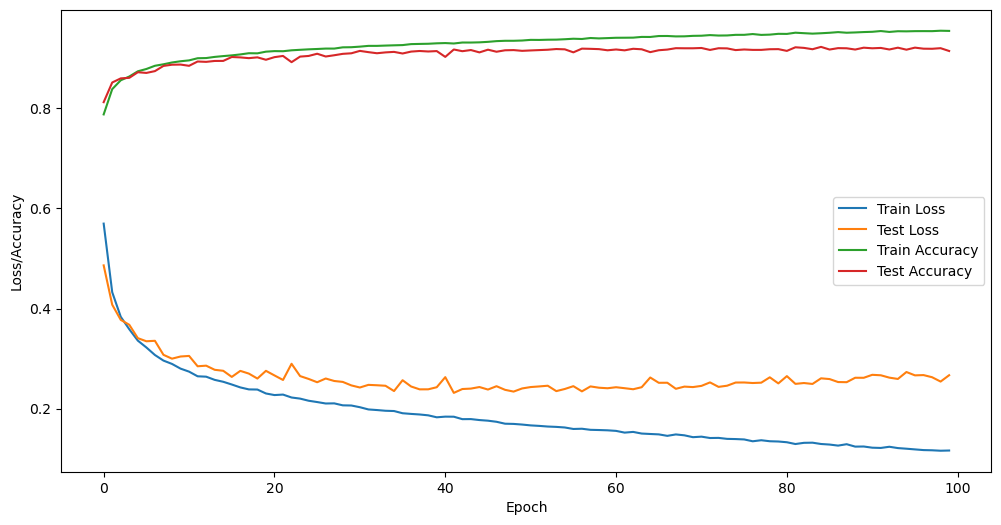

In [70]:
# train_acc = [i.item() for i in train_acc]
# test_acc = [i.item() for i in test_acc]
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()